# Personal Financial Planning

In [1]:
import numpy as np
import pandas as pd
from datetime import date
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.core.display import display, HTML

# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
plt.style.use('ggplot')

## References

<http://pbpython.com/amortization-model-revised.html>  
<https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.financial.html>  
<http://www.financialmodellinghandbook.com/2014/03/15/sign-conventions/>  
<https://cleffinance.blogspot.com/2012/01/pv-pmt-when-to-put-negative.html>  


<https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/>  
<http://inmachineswetrust.com/posts/understanding-generators/#cell3>  
<https://github.com/NelisW/PythonNotesToSelf/blob/master/Generators.ipynb>


## Introduction


**A note on dates:**  The default start date in this notebook is 2000-01-01, mainly because it is easy to calculate the term remaining from a round number.  The date 0000-01-01 is not allowed in the Python code, so I start with the year 2000.

## Simple Financial Calculations

The sign of a financial value is often confusing: some are positive others are negative. 

* When money is taken out from your pocket (outflows, you pay): use a negative sign.  
* When money is given to you (inflows, pay to you), use a positive sign.

When you borrow money, the capital principal is flowing in, it must be positice. The interest and payment due is flowing out, it must be negative.

When you withdraw from an investment, the capital flowed out when making the investment, hence it must be negative.
The withdrawal is flowing in, it must be positive.

In [2]:
Interest_Rate = 0.09
Years = 20
numAnnPayments = 12
Principal = 1000000
start_date = (date(2000,1,1))

How large a monthly payment is required to repay bond?

In [3]:
pmt = np.pmt(Interest_Rate/numAnnPayments, Years*numAnnPayments, Principal)
print(f'Payment required {pmt}')

Payment required -8997.259558501702


How much interest or capital is paid in a specific period (a month in this case)

In [4]:
# Period/month for which to calculate
per = 240

# Calculate the interest
ipmt = np.ipmt(Interest_Rate/numAnnPayments, per, Years*numAnnPayments, Principal)

# Calculate the principal
ppmt = np.ppmt(Interest_Rate/numAnnPayments, per, Years*numAnnPayments, Principal)

print(f'Interest payment {ipmt}, capital repayment {ppmt}')


Interest payment -66.97711830150335, capital repayment -8930.282440200199


## Time Value of Money

Inflation erodes the buying power of money over time.  As long as your salary keeps track, or exceeds, of inflation, the erosion effect might not be very noticeable. However, if your salary increases slower than inflation, your buying power decreases with time.

From the table below it is evident that the value of money halves in 11.5 years if the inflation rate is 6%.

In [5]:
df = pd.DataFrame()
df['Inflation %'] =  np.linspace(3,15,13)
df['Years-to-half'] = -np.log(0.5)/np.log(1+df['Inflation %']/(100*12))/12
df

,Inflation %,Years-to-half
0,3.0,23.13378
1,4.0,17.35754
2,5.0,13.89180
3,6.0,11.58131
4,7.0,9.93096
5,8.0,8.69319
6,9.0,7.73048
7,10.0,6.96031
8,11.0,6.33018
9,12.0,5.80506


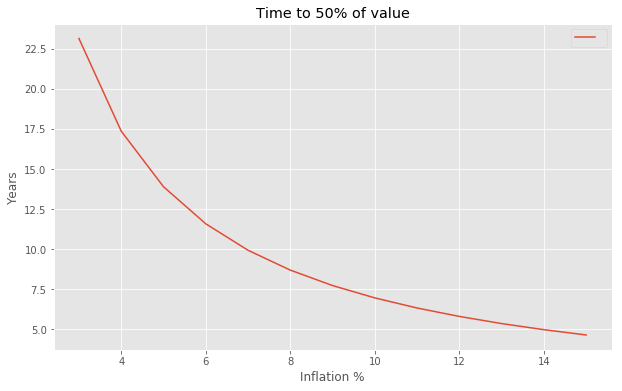

In [6]:
figsize(10,6)
fig, ax = plt.subplots(1, 1)
df.plot(x='Inflation %', y='Years-to-half', label=f'', ax=ax)
plt.title("Time to 50% of value");
plt.ylabel("Years");

Suppose it is possible to freeze the time value of money, to always remain at unity.  With the time value of money frozen, we can evaluate the value of asset growth and costs in a manner decoupled from the erosion effect of inflation: we evaluate the investment or cost in terms of  true buying power.  The money value would always have constant buying power irrespective of time into the future.

Freezing the time value of money is readily done by considering any costs or growth relative to the inflation rate. If the inflation rate is 6% and an investment realises 8% growth, the real growth (corrected for inflation) is 2%.  Hence the effect of inflation on time value of money can be removed by considering all costs and growth relative to inflation: just subtract inflation rate.


## Bond/Mortgage Amortisation Model

This model and code is taken from http://pbpython.com/amortization-model-revised.html. Moffit was looking for a way to do amortisation  calculations in Pandas without loops, but ended up using a generator function to do the looping.  The generator does a complete set of loops and then provides the answer to a Pandas DataFrame.   The power of Pandas is therefore not available during the loop, but it is available afterwards for analysis and plotting.  Moffit's original code is heavily refactored and cleaned up here. 

The algorithm to be executed at every time interval (e.g. every month) is as follows:

1. Calculate the interest on the balance, rounded to two decimals.
1. Calculate the payment as the smaller of the outstanding balance or the contractual payment amount (to account for a smaller payment in the last cycle).
1. Calculate the additional payment as the smaller of the outstanding balance or the fixed additional payment amount (to account for a smaller payment in the last cycle).
1. Calculate the new balance by adding the interest and subtracting the two payments (but account for the signs of the financial values).
1. Calculate some housekeeping values like the date and payment cycle number.

It should be evident that the interest is calculated compound at each payment cycle, hence it adjusts at every payment cycle. 

The `amortise` function below is a Python generator function that provides iterative results for each time interval.  This generator is used to populate a Pandas DataFrame for subsequent anaysis.

In [7]:
def amortise(principal, interest_rate, years, reqpayment, addpayment, start_date, numAnnPayments):
    """
    Calculate the amortization schedule given the loan details.

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    :param reqpayment: Payment amount per period
    :param addpayment: Additional payments to be made each period.
    :param start_date: Start date for the loan.
    :param numAnnPayments: Number of payments in a year.

    :return: 
        schedule: Amortization schedule as an Ordered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = principal
    end_balance = principal
   
    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = - round(((interest_rate/numAnnPayments) * beg_balance), 2)
        
        # Determine payment based on whether or not this period will pay off the loan
        reqpayment = - min(-reqpayment, beg_balance - interest)
        
        # Ensure additional payment gets adjusted if the loan is being paid off
        addpayment = - min(-addpayment, beg_balance - interest + reqpayment)
        
        end_balance = beg_balance - interest  + reqpayment  + addpayment

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('ReqPayment', reqpayment),
                           ('Principal', principal),
                           ('Interest', interest),
                           ('AddPayment', addpayment),
                           ('End Balance', end_balance)])
        
        # Increment the counter, balance and date
        p += 1
        start_date += relativedelta(months=1)
        beg_balance = end_balance


Confirm that the `amortize` function is a generator:

In [8]:
amortise(principal=10000, interest_rate=.03, years=5, reqpayment=-400, addpayment=0, start_date=date(2000, 1,1), numAnnPayments=12)

<generator object amortise at 0x000000000986EB48>

Next create a wrapper function to use `amortize` to fill a Pandas DataFrame.  This function primarily cleans up the table and provides summary stats so it is easy to compare various scenarios.  See the function docstring for the parameters and conventions to be used.



In [9]:
def amortisation_table(principal, interest_rate, years,reqpayment,
                       addpayment=0, numAnnPayments=12, start_date=(date(2000,1,1))):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param principal: Amount borrowed (positive)
    :param interest_rate: The *annual* interest rate for this loan (positive)
    :param years: Number of years for the loan (positive)
    :param reqpayment: minimum required payment to meet the term requirements (negative)
    :param numAnnPayments (optional): Number of payments in a year. Default 12.
    :param addpayment (optional): Additional payments to be made each period as percentage of required payment. Default 0. (negative)
    :param start_date (optional): Start date. Default 2000-01-01 if none provided

    :return: 
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    if addpayment != 0:
        addpayment = reqpayment * addpayment / 100
    
    # Generate the schedule 
    schedule = pd.DataFrame(amortise(principal, interest_rate, years, reqpayment,
                                     addpayment, start_date, numAnnPayments))
    # reorder the columns
    schedule = schedule[["Period", "Month", "Begin Balance", "ReqPayment","AddPayment",
                         "Interest", "End Balance"]]
    
    # Convert to a datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    payoff_date = schedule["Month"].iloc[-1]
    stats = pd.Series([principal,payoff_date, schedule["Period"].count(), interest_rate,
                       years, reqpayment, addpayment,
                       schedule["Interest"].sum()],
                       index=["Principal","Payoff Date", "Num Payments", "Interest Rate", "Years", 
                             "ReqPayment", "AddPayment", "Total Interest"])
    
    return schedule, stats

Example showing how to call the function

In [10]:
principal = 1000000
interest_rate = 0.09
years = 20
numAnnPayments = 12
reqpayment = round(np.pmt(interest_rate/numAnnPayments, years*numAnnPayments, principal), 2)

df, stats = amortisation_table(
    principal=principal, 
    interest_rate=interest_rate, 
    years=30, 
    reqpayment = reqpayment,
    addpayment=2,
    numAnnPayments=numAnnPayments, 
    start_date=date(2000, 1,1))

The `stats` DataFrame provide a summary of the total contract, showing the key values, including the required payment, additional payment (if provided) and the total interest over the full term of the contract.  Note that the principal value is positive (inflow) and the payments and interest are negative (outflow).

In [11]:
stats

Principal                     1000000
Payoff Date       2018-12-01 00:00:00
Num Payments                      228
Interest Rate                    0.09
Years                              30
ReqPayment                    -8997.3
AddPayment                    -179.95
Total Interest            -1.0875e+06
dtype: object

The following table shows the first few and the last few cycles of the schedule. Note that in the first month 83% of the payment is interest: only 17% of the payment is applied towards reducing the loan amount.  Towards the end of the term the interest reduces to a small percentage.

In [12]:
df['IntPercent'] = 100 * df['Interest'] / df['ReqPayment']
display(HTML(df.head().to_html()))
display(HTML(df.tail().to_html()))


,Period,Month,Begin Balance,ReqPayment,AddPayment,Interest,End Balance,IntPercent
0,1,2000-01-01,1000000.0000,-8997.26,-179.9452,-7500.00,998322.7948,83.35871
1,2,2000-02-01,998322.7948,-8997.26,-179.9452,-7487.42,996633.0096,83.21889
2,3,2000-03-01,996633.0096,-8997.26,-179.9452,-7474.75,994930.5544,83.07807
3,4,2000-04-01,994930.5544,-8997.26,-179.9452,-7461.98,993215.3292,82.93614
4,5,2000-05-01,993215.3292,-8997.26,-179.9452,-7449.11,991487.2340,82.79309


,Period,Month,Begin Balance,ReqPayment,AddPayment,Interest,End Balance,IntPercent
223,224,2018-08-01,40116.8204,-8997.2600,-179.9452,-300.88,31240.4952,3.34413
224,225,2018-09-01,31240.4952,-8997.2600,-179.9452,-234.30,22297.5900,2.60413
225,226,2018-10-01,22297.5900,-8997.2600,-179.9452,-167.23,13287.6148,1.85868
226,227,2018-11-01,13287.6148,-8997.2600,-179.9452,-99.66,4210.0696,1.10767
227,228,2018-12-01,4210.0696,-4241.6496,-0.0000,-31.58,0.0000,0.74452


## Bond Repayment Studies

Define a few standard utility functions

In [13]:
def plot_balance(scenarios):
    """Plot the remaining balance of all scenarios
    """
    fig, ax = plt.subplots(1, 1)
    for scenario in scenarios.keys():
        schedules[scenario].plot(x='Month', y='End Balance', label=f'{scenario}', ax=ax)
    plt.title("Repayment Timelines");
    plt.ylabel("Balance");

In [14]:
def plot_annual_interest(schedule, stats):
    """Plot the annual interest of all scenarios
    """
    ys = {}
    labels = {}
    for scenario in scenarios.keys():
        ys[scenario],labels[scenario] = annual_interest(schedules[scenario], stats[scenario])

    dfai = pd.concat([ys[scenario] for scenario in ys.keys()], axis=1)
    # print(dfai)

    figsize(7,5)
    fig, ax = plt.subplots(1, 1)
    dfai.plot(kind="bar", ax=ax)

    plt.legend([labels[scenario] for scenario in labels.keys()], loc=1, prop={'size':10})
    plt.title("Interest Payments");

In [15]:
def annual_interest(schedule, stats):
    """Create a dataframe with annual interest totals, and a descriptive label
    """
    annint = schedule.set_index('Month')['Interest'].resample("A").sum().reset_index()
    annint["Year"] = annint["Month"].dt.year
    annint.set_index('Year', inplace=True)
    annint.drop('Month', 1, inplace=True)
    label="{} years at {}% with additional payment of {:.0f}".format(stats['Years'], stats['Interest Rate']*100, stats['AddPayment'])
    return annint, label



In [16]:
def calc_scenarios(scenarios,numAnnPayments=12,paymentSign=1):
    """Given a scenario dictionary calculate bond schedules and statistics
    """
    schedules = {}
    stats = {}
    
    for scenario in scenarios.keys():
        if 'reqPayment' not in scenarios[scenario].keys():
            scenarios[scenario]['reqPayment'] = \
                paymentSign * round(np.pmt(scenarios[scenario]['intr'] / numAnnPayments, 
                              scenarios[scenario]['years'] * numAnnPayments, 
                              scenarios[scenario]['princ']), 2);
       
        schedules[scenario], stats[scenario] = amortisation_table(
                        scenarios[scenario]['princ'], 
                        scenarios[scenario]['intr'], 
                        scenarios[scenario]['years'], 
                        scenarios[scenario]['reqPayment'], 
                        scenarios[scenario]['addPayment'],
                        numAnnPayments=12
                    );
    return schedules,stats


### Fixed scenario, different additional payments

This calculation shows how the bond/mortgage term can be shortened by adding a fixed percentage (0%, 2%, 10% or 20%) to the required payment.  By increasing the payment the term is shortened significantly and the total money paid is much reduced.

In [17]:
scenarios = {
    '0.04%, add=0%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0,'years':20},
    '0.04%, add=2%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':2,'years':20},
    '0.04%, add=10%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':10,'years':20},
    '0.04%, add=20%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':20,'years':20},
    '0.04%, add=30%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':30,'years':20},
}
        
schedules,stats = calc_scenarios(scenarios) 

In [18]:
dfstats = pd.DataFrame([stats[key] for key in stats.keys()])
dfstats['Years'] = dfstats['Num Payments'] / 12
dfstats['Additional % payment'] = 100 * dfstats['AddPayment'] / dfstats['ReqPayment']
dfstats['Total money paid'] = 1 - dfstats['Total Interest'] / dfstats['Principal']
display(HTML(dfstats.to_html()))

,Principal,Payoff Date,Num Payments,Interest Rate,Years,ReqPayment,AddPayment,Total Interest,Additional % payment,Total money paid
0,1000000,2019-12-01,240,0.09,20.00000,-8997.26,0.0000,-1159342.10,-0.0,2.15934
1,1000000,2018-12-01,228,0.09,19.00000,-8997.26,-179.9452,-1087467.23,2.0,2.08747
2,1000000,2015-10-01,190,0.09,15.83333,-8997.26,-899.7260,-878228.77,10.0,1.87823
3,1000000,2013-03-01,159,0.09,13.25000,-8997.26,-1799.4520,-714178.37,20.0,1.71418
4,1000000,2011-06-01,138,0.09,11.50000,-8997.26,-2699.1780,-604582.36,30.0,1.60458


Notice how the term of the contract dramatically shortens if a fixed additional payment is made. If you pay 30% extra over and above the required payment, the term shortens from 20 years to just under 12 years.

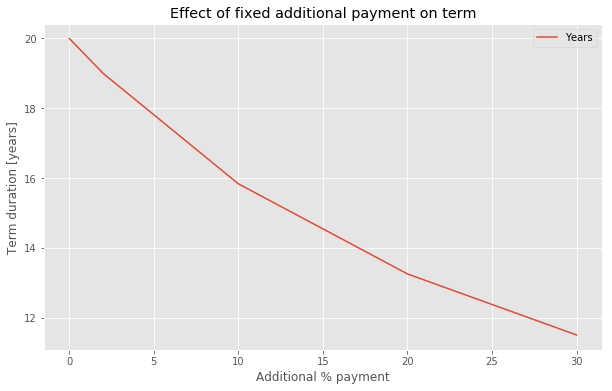

In [19]:
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='Years', ax=ax)
plt.title("Effect of fixed additional payment on term");
plt.ylabel("Term duration [years]");


The next graph shows the total money repaid on the contract as a function of additional payment.  

If no additional payment is made, the total amount paid back over the full term of the contract is 2.16 times the initial loan principal amount.

Notice how the interest dramatically reduces if a fixed additional payment is made. 
If you pay 30% extra over and above the required payment, the total amount paid back over the full term of the contract is 1.6 times the initial loan principal amount.

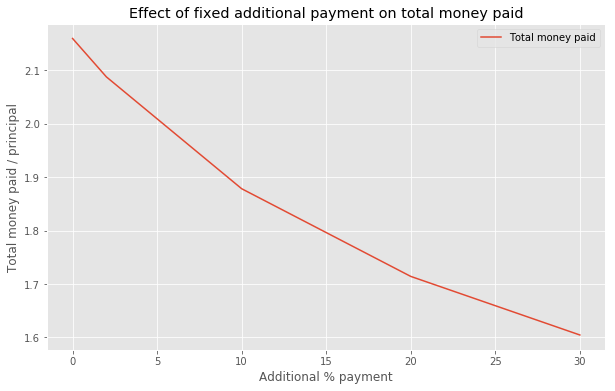

In [20]:
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='Total money paid', ax=ax)
plt.title("Effect of fixed additional payment on total money paid");
plt.ylabel("Total money paid / principal");


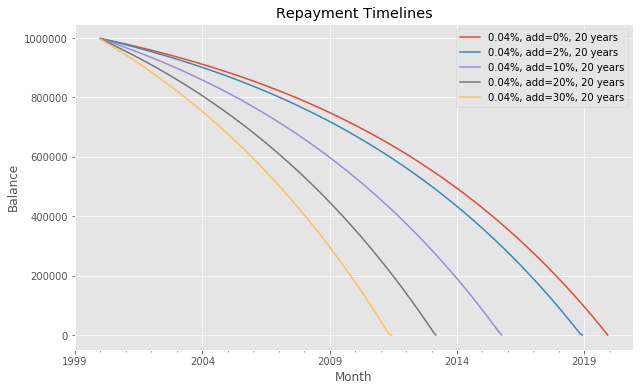

In [21]:
plot_balance(scenarios)

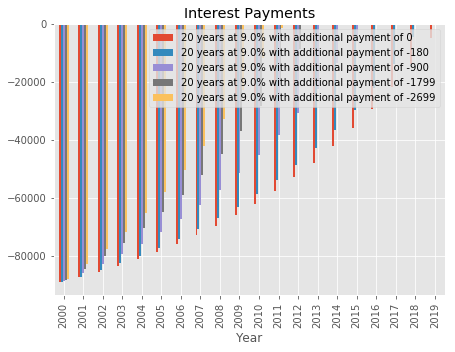

In [22]:
plot_annual_interest(schedules, stats)   

## Retirement Fund Depletion

to be completed

In [23]:
# def amortize(principal, interest_rate, years, reqpayment, addpayment, start_date, annual_payments):
#     """
#     Calculate the amortization schedule given the loan details.

#     :param principal: Amount borrowed
#     :param interest_rate: The annual interest rate for this loan
#     :param years: Number of years for the loan
#     :param reqpayment: Payment amount per period
#     :param addpayment: Additional payments to be made each period.
#     :param start_date: Start date for the loan.
#     :param annual_payments: Number of payments in a year.

#     :return: 
#         schedule: Amortization schedule as an Ordered Dictionary
#     """

#     # initialize the variables to keep track of the periods and running balances
#     p = 1
#     beg_balance = principal
#     end_balance = principal
   
#     while end_balance > 0:
        
#         # Recalculate the interest based on the current balance
#         interest = - round(((interest_rate/annual_payments) * beg_balance), 2)
        
#         # Determine payment based on whether or not this period will pay off the loan
#         reqpayment = - min(-reqpayment, beg_balance - interest)
        
#         # Ensure additional payment gets adjusted if the loan is being paid off
#         addpayment = - min(-addpayment, beg_balance - interest + reqpayment)
        
#         end_balance = beg_balance - interest  + reqpayment  + addpayment

#         yield OrderedDict([('Month',start_date),
#                            ('Period', p),
#                            ('Begin Balance', beg_balance),
#                            ('ReqPayment', reqpayment),
#                            ('Principal', principal),
#                            ('Interest', interest),
#                            ('AddPayment', addpayment),
#                            ('End Balance', end_balance)])
        
#         # Increment the counter, balance and date
#         p += 1
#         start_date += relativedelta(months=1)
#         beg_balance = end_balance
